In [21]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions

In [34]:
@model function coin_model()
    
    a = datavar(Float64)
    b = datavar(Float64)
    y = datavar(Float64)
    
    θ ~ Beta(a, b)
    y ~ Bernoulli(θ)
    
    return y, a, b, θ
end

coin_model (generic function with 1 method)

In [35]:
N = 10000   # number of coin tosses
p = 0.5    # p parameter of the Bernoulli distribution

dataset = float.(rand(Bernoulli(p), N));

In [36]:
function inference(data)
    model, (y, a, b, θ) = coin_model()
    
    prior_a = 1.0
    prior_b = 1.0
    
    fe = Vector{Float64}()
    θs = Vector{Marginal}()
    
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, AsapScheduler()), (f) -> push!(fe, f))
    θ_sub = subscribe!(getmarginal(θ), (m) -> push!(θs, m))
    
    for d in data
        update!(a, prior_a)
        update!(b, prior_b)
        update!(y, d)

        prior_a, prior_b = params(getdata(θs[end]))
    end
    
    unsubscribe!(θ_sub)
    unsubscribe!(fe_sub)
    
    return θs, fe
end

inference (generic function with 1 method)

In [37]:
est, fe = inference(dataset);

In [38]:
using Plots

gr()

Plots.GRBackend()

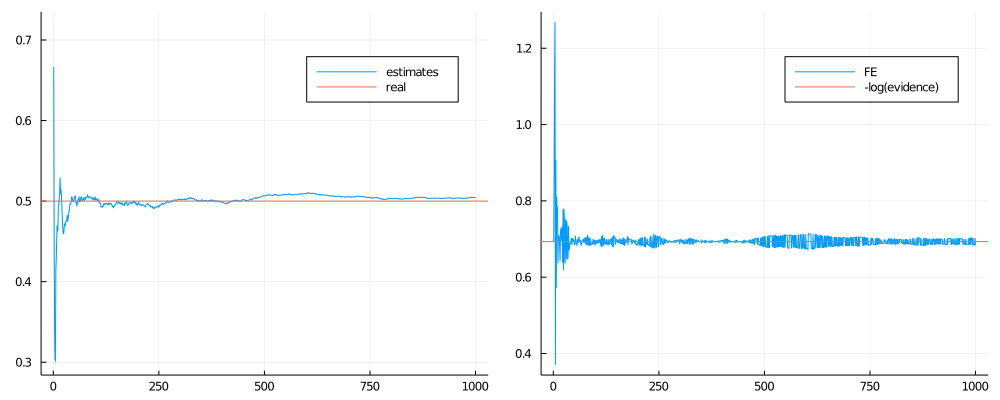

In [39]:
pest = est[1:10:end]
pfe = fe[1:10:end]

p1 = plot(mean.(pest), ribbon = var.(pest), label = :estimates)
p1 = plot!([ p ], seriestype = :hline, label = :real)
 
p2 = plot(pfe, label = :FE)
p2 = plot!([ -log(p) ], seriestype = :hline, label = "-log(evidence)")

plot(p1, p2, layout = @layout([ a b ]), size = (1000, 400))